# The Solow model with land

Imports and set magics:

In [76]:
import numpy as np
from scipy import optimize
import sympy as sm
from sympy import Symbol
from sympy.solvers import solve
sm.init_printing(use_unicode=True) # for pretty printing
from IPython.display import display
import matplotlib.pyplot as plt # baseline modul
import ipywidgets as widgets

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The **Solow model with land** contains:

* $K_t$ is capital
* $L_t$ is labor
* $A_t$ is technology
* $X$ is land
* $Y_t = F(K_t,A_tL_t,X)$ is GDP

**GDP** is defined as

$ Y_{t}=K_{t}^{\alpha}(A_{t}L_{t})^{\beta}X^{\kappa}$

**Saving** is a constant fraction of GDP

$ S_t = sY_t,\, s\in(0,1) $

such that **capital accumulates** according to

$ K_{t+1}=sY_t+(1-\delta)K_t $

**Labour and technology accoumulates** as

$ L_{t+1} = (1+n)L_t $

$ A_{t+1} = (1+g)A_t $

The transition equation then normally becomes

$ \tilde{k}_{t+1}= \frac{1}{(1+n)(1+g)}[\tilde{k}_{t}^{\alpha}(\frac{X}{A_tL_t})^\kappa+(1-\delta)\tilde{k}_{t}] $

where $\tilde{k}_{t}= \dfrac{K_t}{A_tL_t}$

But in this case we need to look at the capital-output ratio, so the **transition equation** becomes

$ z_{t+1} = \frac{K_{t+1}}{Y_{t+1}} = \frac{K_{t+1}}{K_{t+1}^{\alpha}(A_{t+1}L_{t+1})^{\beta}X^{\kappa}} = \frac{K_{t+1}^{1-\alpha}}{(A_{t+1}L_{t+1})^{\beta}X^{\kappa}} \rightarrow z_{t+1} = \frac{1}{((1+g)(1+n))^\beta}(s+z_t(1-\delta))^{1-\alpha}z_t^\alpha$

# Steady state

## Analytical solution

We use **sympy** to find an analytical expression for the steady state, i.e. solve

$$ z^{\ast} = \frac{1}{((1+g)(1+n))^\beta}(s+z^{\ast}(1-\delta))^{1-\alpha}(z^{\ast})^\alpha $$

In [77]:
#We define all symbols
k = sm.symbols('k') #physical capital
X = sm.symbols('X') #land
z = sm.symbols('z') # #physical capital/GDP ratio
alpha = sm.symbols('alpha') #return on physical capital
beta = sm.symbols('beta') #labour force income share
kappa = sm.symbols('kappa') #return on land
delta = sm.symbols('delta') #depreciation rate on capital
s = sm.symbols('s') #savings/investment rate
g = sm.symbols('g') #growth in technology
n = sm.symbols('n') #growth in labour force

In [78]:
ss = sm.Eq(((s+z*(1-delta))**(1-alpha)*z**alpha)/((1+g)*(1+n))**beta)
ssz = sm.solve(ss,z) [0]
sm.Eq(z,ssz)

/var/folders/b7/xr_h9h1s35l0rntn_yj3w_9h0000gn/T/ipykernel_36015/2925422272.py:1: SymPyDeprecationWarning: 

Eq(expr) with a single argument with the right-hand side
defaulting to 0 is deprecated. Use Eq(expr, 0) instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-eq-expr
for details.

This has been deprecated since SymPy version 1.5. It
will be removed in a future version of SymPy.

  ss = sm.Eq(((s+z*(1-delta))**(1-alpha)*z**alpha)/((1+g)*(1+n))**beta)


When using $ 1 - \alpha = \beta + \kappa $, this can be reduced to:

$$ z_t = z = z^{\ast} = \frac{s}{((1+g)(1+n))^\frac{\beta}{\beta+\kappa}-(1-\delta)} $$

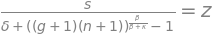

In [79]:
zss = sm.Eq(s/(((1+g)*(1+n))**(beta/(beta+kappa))-(1-delta)),z)
zss

We rewrite the equation for the steady state as

$ 0 = \frac{s}{((1+g)(1+n))^\frac{\beta}{\beta+\kappa}-(1-\delta)} -z^{\ast} $


now it is a root-finding problem.

In [80]:
#We define model parameters as plausible empirical values
s = 0.2
g = 0.02
n = 0.01
beta = 0.6
kappa = 0.2
alpha = 0.2
delta = 0.06

In [81]:
z = s/(((1+g)*(1+n))**((beta)/((beta)+(kappa)))-(1-delta))
z

## Numerical solution

We da a simulation-based optimization using the objective function that is subject to constraints. It can be evaluated through a stochastic simulation, which will result in the numerical solution.

The optimization algorith begins by making a pool of possible solutions based on the variables. The algorith makes sure there is no violations of constraints and gives the optimial solution.

In [82]:
def sim(s = 0.2):
    #s = 0.2
    g = 0.02
    n = 0.01
    beta = 0.6
    kappa = 0.2
    alpha = 0.2
    delta = 0.06
    X = 0.5

    def prod(K, A, L, X):
        return K ** alpha * (A * L) ** beta * X ** kappa

    T = 200
    Ks = np.zeros(T)
    Ys = np.zeros(T)
    Ls = np.zeros(T)
    As = np.zeros(T)
    Zs = np.zeros(T)

    Ks[0] = 0.5
    Ls[0] = 1.0
    As[0] = 2.0
    Ys[0] = prod(Ks[0], As[0], Ls[0], X)
    for t in range(1, T):
        Ks[t] = s * Ys[t-1] + (1 - delta) * Ks[t-1] 
        Ls[t] = (1 + n) * Ls[t-1]
        As[t] = (1 + g) * As[t-1]
        Ys[t] = prod(Ks[t], As[t], Ls[t], X)

    Zs = Ks / Ys
    return Ks, Ys, Ls, As, Zs

Ks, Ys, Ls, As, Zs = sim()
# SS must be last value **care only if we converge before 200 periods #
print(f'SS: {Zs[199]}')

SS: 2.422314240831781


As expected, the numerical solution and the analytical solution is the same.

We now illustrate the simulated path for z over time:

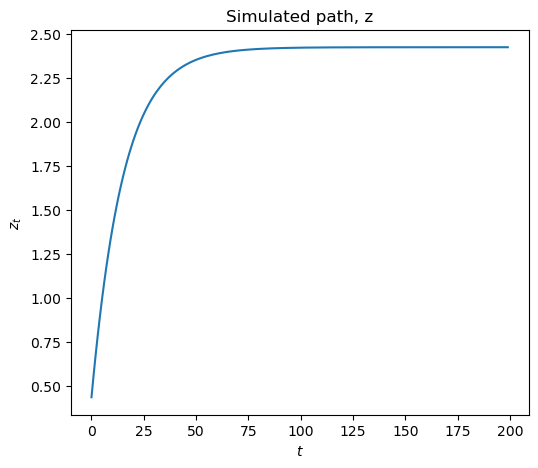

In [83]:
fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(1,2,1)
ax.plot(Zs)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$z_t$')

ax.set_title('Simulated path, z');

We can see that z converges towards steady state over time.

# Solow-diagram

In [84]:
def z_func(s,g,n,alpha,beta,delta,time):
    """
    args:
    s     (float): Investments
    g     (float): Growth in technology
    n     (float): Growth in labour force
    delta (float): Depreciation rate 
    alpha (float): Return on physical capital
    beta  (float): Labour force income share
    time    (int): Periods
    
    Returns:
    The solow diagram with a diagonal line and the growth path of z"""
    
    #An emty list is made to contain the k values
    z_growth = [z]
    
    #An empty list is made to contain the diagonal line
    diagonal = [0]


    #45 degree line
    for t in range(1,time):
        line = (n+delta+g+n*g)*t
        diagonal.append(line)

        
    #We generate the growth in capital
    for t in range(1,time):
        z_tp1 = ((s)**(1-alpha)*t**alpha)
        z_growth.append(z_tp1)
    
    #Create the plot
    plt.rcParams['axes.facecolor'] = 'white'
    plt.figure(figsize=(6,6))
    plt.plot(z_growth[:time], label=r'$s^{1-\alpha}z_t^{\alpha}$', color = 'blue')
    plt.plot(diagonal[:time], label = r'$(n+\delta+g+ng)z_t$', color = 'red')
    plt.xlim(0,time)
    plt.ylim(0,diagonal[-1])
    plt.xlabel('$z_t$')
    plt.legend()
    plt.title('Solow diagram')
    
    return plt.show()

In [85]:
widgets.interact(z_func, 
                z = widgets.fixed(0), 
                alpha = widgets.FloatSlider(description = r'$\alpha$', min = 0, max = 0.9, step = 0.05, value = 0.2),
                delta = widgets.FloatSlider(description = r'$\delta$', min = 0, max = 0.1, step = 0.01, value = 0.06),
                s = widgets.FloatSlider(description = '$s$', min = 0.01, max = 0.8, step = 0.05, value = 0.2),
                n = widgets.FloatSlider(description ='$n$', min = 0.01, max = 0.1, step = 0.005, value = 0.01),
                g = widgets.FloatSlider(description ='$g$', min = 0.02, max = 0.2, step = 0.005, value = 0.02),
                beta = widgets.fixed(2/3),
                time = widgets.IntSlider(description='time', min = 1, max = 1000, step = 10, value = 30))

interactive(children=(FloatSlider(value=0.2, description='$s$', max=0.8, min=0.01, step=0.05), FloatSlider(val…

<function __main__.z_func(s, g, n, alpha, beta, delta, time)>

The Solow diagram visualize how the steady state changes with different parameter values. For example, an increase in s (the saving rate) results in a higher value for the steady state, while a higher delta (depreciation rate on capital) results in a lower steady state value.

# Golden Rule

We calculate the golden rule for  private consumption for the Solow model with land.

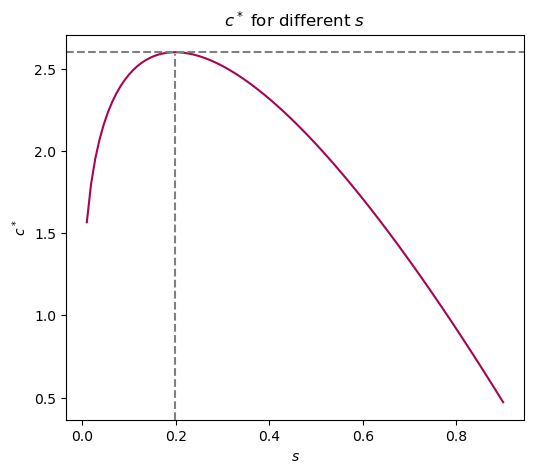

In [86]:
ss = np.linspace(0.01, 0.9, 100)

cs = []
for s in ss: 
    Ks, Ys, Ls, As, Zs = sim(s)
    y = Ys / Ls
    cs.append( (1 - s) * y[50]  )


fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(1,2,1)
ax.plot(ss,cs, color='#a60550')
ax.set_xlabel(r'$s$')
ax.set_ylabel(r'$c^*$')

# ss[cs.index(max(cs))]
# -> finds value in s grid for the max c value
plt.axvline(ss[cs.index(max(cs))],ymax=0.95,color='gray',linestyle='--')
plt.axhline(max(cs),xmax=1,color='gray',linestyle='--')
ax.set_title('$c^*$ for different $s$');

In [95]:
#We find the largest ss-value of consumption pr. worker
print(f'The maximum private consumption per capita is: {max(cs):.3f}')

#We find the sh value resulting in the maximum c value
print(f'The golden rule value of s is: {(ss[cs.index(max(cs))]):.3f}')

The maximum private consumption per capita is: 2.600
The golden rule value of s is: 0.199


The savings rate that maximises private consumption is 0.199, which is close value used throughout this project and can be empirically considered a normal saving rate.

# Conclusion

We have investigated a Solow model with land. With our chosen parameter values, a steady state arises with a value of 2.422 with both a analytical and numerical approach. Further investigations show the influence of the parameter values. Finally, we find the golden rule, which have golden rule saving rate value of 0.199 and a maximum private consumption per capita at 2.6.